In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RegularGridInterpolator
from dataclasses import dataclass
import time

# Finite Difference Method for the GALA Problem: Mathematical Formulation

## 1. Problem Statement

We seek the potential distribution $\phi(x,z)$ in a device with several electrodes arranged in the $z$-direction and along one horizontal dimension $x$. The electrodes are defined as follows:

- **Reference Electrode:** Located at $z = l_3$ with potential $V_0$ 
- **Gate:** Located at $z = l_2$ with potential $V_g$ 
- **Anode:** Located at $z = l_1$ with potential $V_a$ 
- **Ground:** Located at $z = 0$ with potential 0.

The geometry includes a dielectric layer with two holes in the $x$-direction, through which the gate and anode are connected. The holes are defined by:
- **Hole 1:** Centered at $x = x_1$ with diameter $d_1$.
- **Hole 2:** Centered at $x = x_2 = x_1 + p$ (with $p$ being the pitch.

The region of interest in \(x\) is given by:
$$
x \in \left[ x_1 - \frac{p}{2},\; x_2 + \frac{p}{2} \right].
$$

## 2. Domain and Boundary Conditions

**Domain:**
- $x \in \left[x_{\min}, x_{\max}\right]$, where:
  $$
  x_{\min} = x_1 - \frac{p}{2}, \quad x_{\max} = x_2 + \frac{p}{2}.
  $$
- $z \in [0, l_3]$.

**Boundary Conditions in $x$:**
- **Neumann (Zero Normal Derivative) at $x=x_{min}$ and $x=x_{max}$:**
  $$
  \frac{\partial \phi}{\partial x} \Big|_{x=x_{\min}} = 0, \quad \frac{\partial \phi}{\partial x} \Big|_{x=x_{\max}} = 0.
 $$
  For example, at $x = x_{min}$ (left boundary), one may enforce:
  $$
  \phi(-\Delta x,z) = \phi(\Delta x,z),
  $$
  leading to a one-sided finite difference.

**Boundary Conditions in $z$:**
- **Dirichlet Conditions:**
  - At $z = 0$: $\phi(x, 0) = 0$ (ground).
  - At $z = l_3$: $\phi(x, l_3) = V_0$.
- **Electrode Conditions on Intermediate Planes:**
  - At $z = l_1$ (anode) and $z = l_2$ (gate), Dirichlet conditions are applied **only** for those $x$ that lie within the holes:
    - For Hole 1: $x \in \left[x_1 - \frac{d_1}{2}, x_1 + \frac{d_1}{2}\right]$.
    - For Hole 2: $x \in \left[x_2 - \frac{d_1}{2}, x_2 + \frac{d_1}{2}\right]$.

## 3. Finite Difference Discretization

### Laplace's Equation

In the absence of free charges, Laplace's equation is given by:
$$
\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial z^2} = 0.
$$

### Discretization in the Interior

Using central finite differences, at an interior grid point $(i, j)$ we approximate:
- **In $x$:**
  $$
  \frac{\partial^2 \phi}{\partial x^2} \approx \frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2}.
  $$
- **In $z$:**
 $$
  \frac{\partial^2 \phi}{\partial z^2} \approx \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta z^2}.
  $$

The discrete Laplace equation at an interior point then becomes:
$$
\frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta z^2} = 0.
$$

### Discretization at the Neumann Boundaries (in $x$)

At the left boundary $i = 0$ with a zero derivative:
$$
\frac{\partial \phi}{\partial x}\Big|_{i=0} = 0,
$$
we assume symmetry:
$$
\phi_{-1,j} = \phi_{1,j}.
$$
Substituting into the central difference formula:
$$
\frac{\phi_{1,j} - 2\phi_{0,j} + \phi_{1,j}}{\Delta x^2} = \frac{2\phi_{1,j} - 2\phi_{0,j}}{\Delta x^2} = \frac{2}{\Delta x^2} (\phi_{1,j} - \phi_{0,j}).
$$
This leads to the finite difference equation:
$$
\frac{2}{\Delta x^2}\phi_{0,j} + \frac{2}{\Delta x^2}\phi_{1,j} = 0,
$$
with coefficients:
- For the center point $\phi_{0,j} = -\frac{2}{\Delta x^2}$.
- For the right neighbor $\phi_{1,j} = \frac{2}{\Delta x^2}$.

A similar procedure is applied at the right boundary.

### Dirichlet Conditions

For grid points where the potential is specified (e.g., at $z=0$, $z=l_3$, or within the holes at $z=l_1$ and $z=l_2$, the equation is replaced by:
$$
\phi_{i,j} = \text{specified value}.
$$
In the linear system, this is enforced by setting the coefficient of $\phi_{i,j}$ to 1 and all other coefficients in that row to 0.

## 4. Assembly of the Sparse Linear System

### Flattening the 2D Grid

The 2D grid is mapped into a 1D vector by indexing:
$$
k = j \times N_x + i,
$$
where $N_x$ is the number of grid points in $x$.

### Formulating the Linear System

For each grid point $(i, j)$:

- **Interior Points:**  
  The finite difference discretization yields contributions from the central point and its four neighbors. For example:
  $$
  \left(-\frac{2}{\Delta x^2} - \frac{2}{\Delta z^2}\right) \phi_{i,j} + \frac{1}{\Delta x^2}\phi_{i+1,j} + \frac{1}{\Delta x^2}\phi_{i-1,j} + \frac{1}{\Delta z^2}\phi_{i,j+1} + \frac{1}{\Delta z^2}\phi_{i,j-1} = 0.
  $$

- **Neumann Boundaries (in $x$):**  
  For example, at the left boundary:
  $$
  -\frac{2}{\Delta x^2}\phi_{0,j} + \frac{2}{\Delta x^2}\phi_{1,j} = 0.
  $$

- **Dirichlet Points:**  
  At these points, the equation is:
  $$
  \phi_{i,j} = \text{specified value}.
  $$

### Sparse Matrix Structure

- The coefficient matrix $A$ is sparse because each grid point only interacts with a few neighboring points.
- Nonzero coefficients from the finite difference stencil are assembled into $A$ using the flattened index.
- The right-hand side vector $b$ collects contributions from known Dirichlet values.

The final linear system is:
$$
A \boldsymbol{\phi} = \boldsymbol{b},
$$
where $\boldsymbol{\phi}$ is the vector of unknown potentials.

## 5. Electric Field and Electron Transport

### Electric Field

Once the potential $\phi(x,z)$ is computed, the electric field is given by:
$$
\mathbf{E}(x,z) = -\nabla \phi(x,z).
$$
The components are approximated using finite differences:
- Inb$x$:
  $$
  E_x \approx -\frac{\phi_{i+1,j} - \phi_{i-1,j}}{2\Delta x} \quad \text{(central difference)},
  $$
- In $z$:
  $$
  E_z \approx -\frac{\phi_{i,j+1} - \phi_{i,j-1}}{2\Delta z} \quad \text{(central difference)}.
  $$

### Electron Transport

Electrons are simulated by initializing them at $z = l_3$ with uniformly spaced $x$-positions and moving them along the negative gradient of $\phi$ (i.e., opposite to the electric field, since electrons are negatively charged). 

Using Euler integration, the position is updated as:
$$
\mathbf{r}_{\text{new}} = \mathbf{r}_{\text{old}} + \Delta t \, \hat{\mathbf{E}},
$$
where $\hat{\mathbf{E}}$ is the unit vector in the direction of the local electric field (i.e., the electric field vector normalized to unit length). This integration continues until the electron reaches the anode (e.g., $z \leq l_1$.



In [8]:
from gala import X1Params, GalaParams, phixz1h, contour_phi, exz, simulate_electron_transport, electron_transport
from gala import contour_phi, phi2d, plot_traj, plot_traj2, heatmap_phi

In [38]:
V=1e+3
kV = 1e+3*V
mm = 1.0
cm = 10.0*mm
atm = 10.0

In [195]:
x1 = 0.0*mm  # position in mm.
d1 = 2.5*mm  # diameter
p  = 2.5*mm  # half pitch

x_min = x1-p
x_max = x1+p
zgrnd = 0.0 * mm  # z of ground.
zagap = 2.0 * mm  # gap between anode and grond
zanode = zgrnd + zagap
dzel = 5.0 * mm # dz of the EL region
zgate = zanode + dzel
dzdr = 10.0 * mm # dz of the drift region
zdrft = zgate + dzdr # top of the drift.

ndr = 2   # number of virtual electrodes the drift.
nel = 1     # number of virtual electrondes in EL

eel = 10*kV  # in 5 mm
edr = 500*V  # in 10 mm
Va = 0*V

vg = np.array([Va - i * eel/nel for i in range(nel)])
Vg = vg[-1]- eel/nel

vd = np.array([Vg - i * edr/ndr for i in range(ndr)])
Vd = vd[-1] - edr/ndr

zdr = np.array([zgate + i*dzdr/ndr for i in range(ndr)])
zel = np.array([zanode + i*dzel/nel for i in range(nel)])


print(f"Hole in position {x1} mm with diameter {d1} mm.")
print(f"Region between {x_min} mm and {x_max} mm.")
print(f"drift length {dzdr} mm; EL length {dzel} mm.")
print(f"zgnd = {zgrnd} mm, zanode = {zanode} mm; zgate = {zgate} mm, zdrft = {zdrft} mm; ")
print(f"Voltage anode: Va = {Va/V} V, Voltage gate: Vg = {Vg/V} V, Voltage Drft : Vd = {Vd/V} V")

print(f"virtual drift planes: z = {zdr/mm} mm")
print(f"virtual EL planes: z = {zel/mm} mm")
print(f"virtual EL planes: vg = {vg/V} V")
print(f"Virtual drft planes: vd = {vd/V} V")


Hole in position 0.0 mm with diameter 2.5 mm.
Region between -2.5 mm and 2.5 mm.
drift length 10.0 mm; EL length 5.0 mm.
zgnd = 0.0 mm, zanode = 2.0 mm; zgate = 7.0 mm, zdrft = 17.0 mm; 
Voltage anode: Va = 0.0 V, Voltage gate: Vg = -10000.0 V, Voltage Drft : Vd = -10500.0 V
virtual drift planes: z = [ 7. 12.] mm
virtual EL planes: z = [2.] mm
virtual EL planes: vg = [0.] V
Virtual drft planes: vd = [-10000. -10250.] V


In [196]:
xparams = X1Params(x1, d1, p, zgrnd, zanode, zgate, zdrft, dzel, dzdr, ndr, nel, vg, vd,
                   zdr, zel, Va, Vg, Vd)

In [197]:
x, z, phi = phixz1h(xparams, Nx, Nz)


    Nx = 1000, Nz = 200
    x1 = 0.0, p = 2.5, d = 2.5
    x_min = -2.5, x_max = 2.5
    zdr = [ 7. 12.]
    j_zd = [0]
    zel = [2.]
    j_ze = [0]
    j_zgrnd = 0
    j_zanode = 23
    j_zgate = 82
    j_zdrft = 199

    print params = X1Params(x1=0.0, d1=2.5, p=2.5, zgrnd=0.0, zanode=2.0, zgate=7.0, zdrft=17.0, dzel=5.0, dzdr=10.0, ndr=2, nel=1, vg=array([0.]), vd=array([-10000000., -10250000.]), zdr=array([ 7., 12.]), zel=array([2.]), Va=0.0, Vg=-10000000.0, Vd=-10500000.0)
    


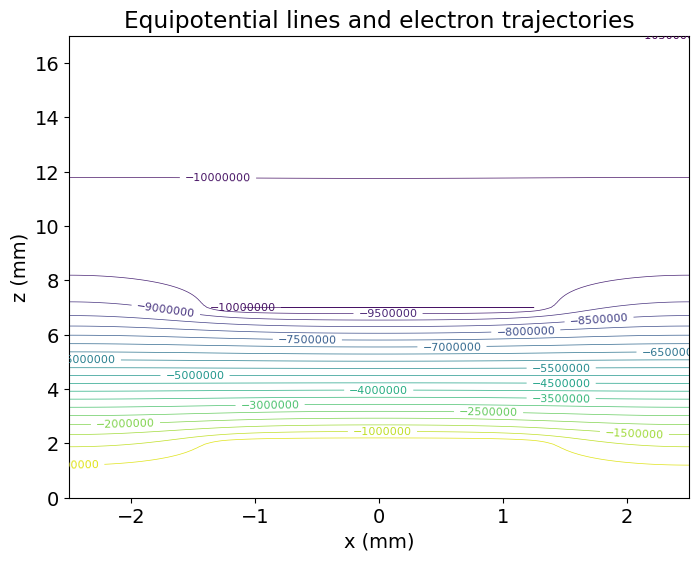

In [198]:
contour_phi(x, z, phi, figsize=(8,6))

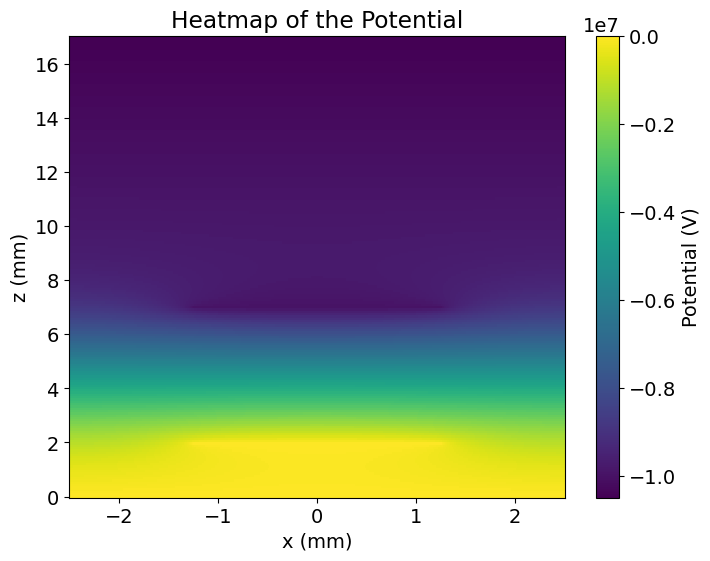

In [199]:
heatmap_phi(x, z, phi, figsize=(8,6))

In [200]:
E_x, E_z = exz(x, z, phi, Nx, Nz)

In [201]:
n_electrons = 100
electron_x0 = np.linspace(x_min, x_max, n_electrons)

In [202]:
ftrj, btrj = electron_transport(x, z, E_x, E_z, electron_x0, xparams, dt=0.1, max_steps=5000)

Error in interpolation for pt = [16.8 -2.5], pt[0] = 16.799999999999997, pt[1]=-2.5000000024428712
Error in interpolation for pt = [16.8  2.5], pt[0] = 16.799999999999997, pt[1]=2.5000000024428712


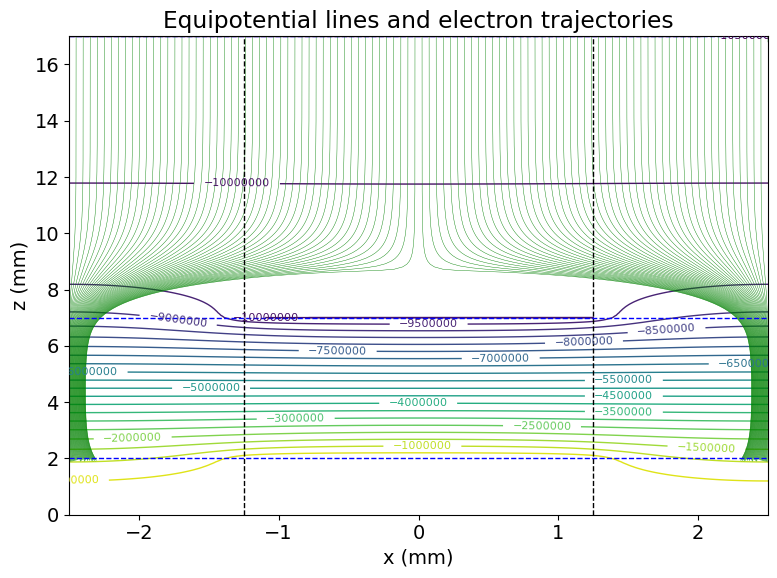

In [203]:
plot_traj2(x, z, phi, ftrj, btrj, xparams, figsize=(8,6))

## Calculation

In [413]:
# -------------------------
# Parameters (all units in mm, V)
# -------------------------
# Electrode positions in z
#l0 = 0.0      # ground, z=0, potential = 0 V
#l1 = 3.0      # anode, z=l1, potential = Va
#l2 = 8.0     # gate, z=l2, potential = Vg
#l3 = 14.0     # reference electrode, z=l3, potential = V0

l0 = -8.0      # ground, z=0, potential = 0 V
l1 = -5.0      # anode, z=l1, potential = Va
l2 = 0.0     # gate, z=l2, potential = Vg
l3 = 8.0     # reference electrode, z=l3, potential = V0

V0 = -150500e+3  # potential at z=l3
Vg = -15000e+3  # potential at gate (only in hole)
Va = 100e+3    # potential at anode (only in hole)


# Hole geometry in x
x1_center = -2.5    # center of hole 1 (mm)
p = 5.0             # pitch between holes (mm)
d1 = 2.5            # hole diameter (mm)
x2_center = x1_center + p

# x-domain: from x1 - p/2 to x2 + p/2
x_min = x1_center - p/2
x_max = x2_center + p/2

params = GalaParams(x1_center, d1, p, l0, l1 , l2, l3, Va, Vg, V0)

# -------------------------
# Discretization
# -------------------------
Nx = 500  # number of grid points in x
Nz = 200  # number of grid points in z

print(f"x1_center ={x1_center}, x2_center ={x2_center}, pitch ={p}, diameter = {d1}")


x1_center =-2.5, x2_center =2.5, pitch =5.0, diameter = 2.5


In [414]:
x, z, phi = phi2d(params, Nx, Nz)


    Nx = 500, Nz = 200
    x1 = -2.5, x2 = 2.5, p = 5.0, d = 2.5
    x_min = -5.0, x_max = 5.0
    


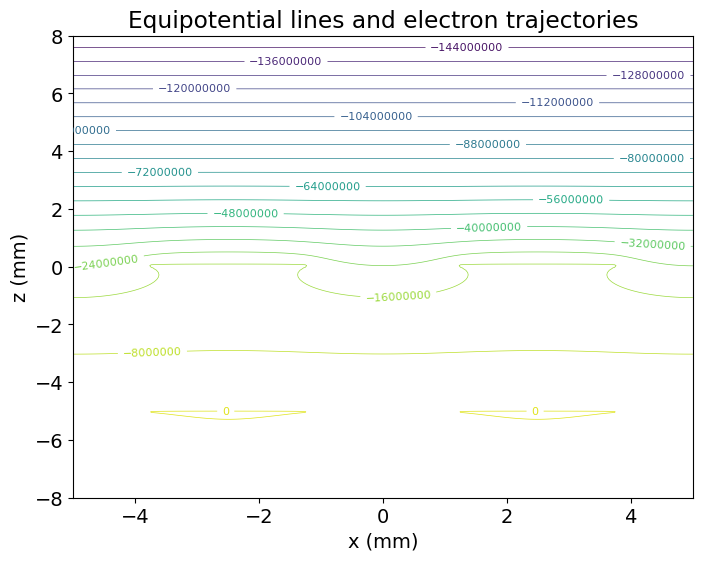

In [415]:
contour_phi(x, z, phi, figsize=(8,6))

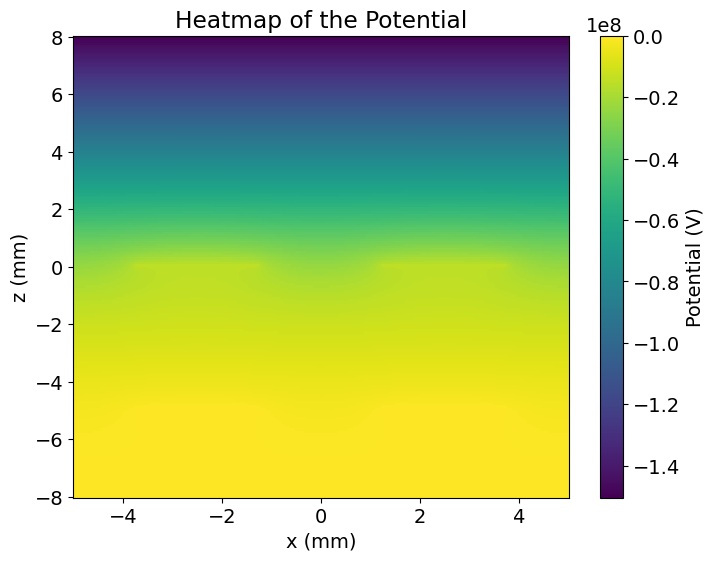

In [416]:
heatmap_phi(x, z, phi, figsize=(8,6))

In [417]:
E_x, E_z = exz(x, z, phi, Nx, Nz)

In [418]:
n_electrons = 100
electron_x0 = np.linspace(x_min, x_max, n_electrons)
#electron_x0 = [-2.3, -2.4, -2.5, -2.6]
electron_z0 = params.l3 
electron_zend = params.l1 

In [419]:
ftrj, btrj = simulate_electron_transport(x, z, E_x, E_z, electron_x0, params, dt=0.1, max_steps=5000)

start_z =8.0, stop_anode_z =-5.0, stop_gnd_z = -8.0


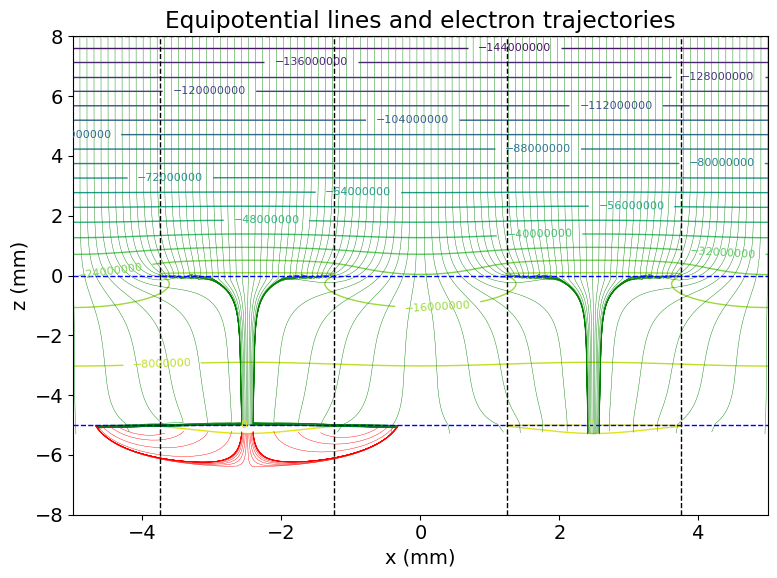

In [420]:
plot_traj(x, z, phi, ftrj, btrj, params, figsize=(8,6))